<h1>From the top!</h1>

We decided to use the Yelp api, demographic census information, and education data to explore potential correlations. Below is an outline of our projec:

<ul>
<li>Import dependencies</li>
<li>Read in CSV data files</li>
<li>Define US regions based on states</li>
<li>Create main DataFrame (res_df)</li>
<li>Coded a for loop to make our API calls and append to res_df</li>
<li>Exported res_df to a CSV file</li>
<li>Cleaned up res_df (ex: combine American (new) and American (Traditional) </li>
<li>Merged our res_df and our counties CSV file</li>
<li>Examine category distribution across the US</li>
<li>KYRUS? </li>
<li>KYRUS?</li>
<li>Display pie charts for each county thay show restaurant category distribution</li>
<li>Examined price breakdown based on region and restaurant category</li>
<li>Produced graphs to illustrate our findings</li>
<li>MONICA - Compared Pricing and Income?</li>
<li>MONICA - </li>
<li>Catherine - EDUCATION</li>
<li>Conclusions</li>
<li>Limitations </li>
<li>If we only had more time...</li>
</ul>

<h3>Part 1: Initial Setup</h3>

Below, we imported all of our dependencies including the yelpapi needed for the project. Next, we brought in all of our outside data files, These files include county data, census data, and education data. These were all source from government websites and were CSV files. 

Once the CSV files were read in, we modified them as needed to fit in out dataframe. To check the formatting, we used a print statement. 

In [3]:
!pip install yelpapi
!pip install numpy
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


<h3>Part 1: County Setup</h3>

In the framework portion, we established regions of the US that we will use later, created a new dataframe that holds out counties, and created a list to hold all the randomly generated countries. This will be more important later. 

In [4]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [5]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['Kern County, California',
 'Kitsap County, Washington',
 'Estill County, Kentucky',
 'Douglas County, Missouri',
 'Logan County, Colorado',
 'Brazoria County, Texas',
 'Sumter County, South Carolina',
 'Benton County, Tennessee',
 'Frederick County, Maryland',
 'Essex County, Massachusetts']

<h3>Part 1: Establishing the Main DataFrame</h3>

After reading in the county data and creating regions, we established our primary dataframe. We named the dataframe res_df. This dataframe will be used throughout the project. 

In [6]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price","region"])
res_df

,name,zipcode,county_string,rating,review_count,category,price,region


<h3>Part 1: The Framework - Kyrus For Loop</h3>

Kyrus was able to build the primary framework for our project. With multiple nested for loops, Kyrus was able to make the Yelp API call, loop through the first 50 pages for each restuarunt type, then red in that data and append it to the res_df dataframe. 

Kyrus also included a try/ecxcept option as a way to check or verify the code was working and pulling in the data correctly. 

In [7]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American (Traditional)","American (New)","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"])==str(term)) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                                    
                                    print("\n",responsejson["businesses"][x]["name"],
                                        responsejson["businesses"][x]["location"]["zip_code"],
                                        zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        responsejson["businesses"][x]["categories"][y]["title"])
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                        str(zc),
                                        county_string,
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        term,
                                        responsejson["businesses"][x]["price"],
                                        "region"
                                                  ]
                                    count += 1
                                    r += 1
                except:
                    
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            print("Error: this shouldn't happen")
            break



 Uricchio's Trattoria 93301 Kern County, California 4.0 288 Italian

 Luigis 93305 Kern County, California 4.0 246 Italian

 Frugatti's Italian Eatery 93309 Kern County, California 4.0 430 Italian

 Perfetto Italian Restaurant 93561 Kern County, California 4.5 65 Italian

 Sorella Ristorante Italiano 93313 Kern County, California 3.5 194 Italian

 Joseph's Italian Restaurant 93301 Kern County, California 3.5 143 Italian

 Little Italy 93311 Kern County, California 3.5 101 Italian

 Rosa's Italian Restaurant 93306 Kern County, California 3.5 143 Italian

 That's Italian 93238 Kern County, California 4.0 92 Italian

 Sandrini's Public House 93301 Kern County, California 3.5 123 Italian

 Olive Garden Italian Restaurant 93309 Kern County, California 3.5 254 Italian

 Mama Tosca's Ristorante Italiano 93311 Kern County, California 3.0 91 Italian

 Giovanni's Italian Eatery 93263 Kern County, California 4.0 35 Italian

 Slice of Italy 93301 Kern County, California 3.5 149 Italian

 TK's Piz


 Zaika Indian Cuisine 93309 Kern County, California 4.0 417 Indian

 India Bistro 93309 Kern County, California 4.5 137 Indian

 The Indian Oven 93307 Kern County, California 4.0 64 Indian

 New Taj Palace Indian Restaurant 93309 Kern County, California 4.0 126 Indian

 Punjabi Dhaba 93307 Kern County, California 5.0 8 Indian

 Haveli Indian Grill 93311 Kern County, California 4.5 94 Indian

 Taj Mahal Cuisine of India 93309 Kern County, California 4.0 133 Indian

 Masala Grill 93309 Kern County, California 4.0 56 Indian

 Kelly's Tandoori Grill 93301 Kern County, California 4.5 31 Indian

 All India Sweets & Grocery 93309 Kern County, California 4.5 38 Indian

 Taste of India  93206 Kern County, California 3.5 539 Indian

 ALL INDIA SWEETS & GROCERY 93313 Kern County, California 4.5 4 Indian

 24 Seven Travel Plaza 93307 Kern County, California 1.0 1 Indian

 Veneto Italian Restaurant 98383 Kitsap County, Washington 4.0 100 Italian

 Burrata Bistro 98370 Kitsap County, Washington 4.5


 Steam Engine Pizza Pub 40336 Estill County, Kentucky 4.5 7 Italian

 Pizza Hut 40336 Estill County, Kentucky 4.5 3 Italian

 La Cabaña 40336 Estill County, Kentucky 4.0 5 Mexican

 Hong Kong Restaurant 40336 Estill County, Kentucky 2.5 2 Chinese

 Old Timers Market 40472 Estill County, Kentucky 4.5 2 American (Traditional)
End of list. Found 0 American (New) restaurants in Estill County, Kentucky
End of list. Found 0 Italian restaurants in Douglas County, Missouri
End of list. Found 0 Italian restaurants in Douglas County, Missouri

 Pizza Hut 65608 Douglas County, Missouri 2.0 1 Italian

 Guacamole Mexican Restaurant 65608 Douglas County, Missouri 4.0 4 Mexican

 Taco Bell 65608 Douglas County, Missouri 5.0 1 Mexican

 Ruby Garden 65608 Douglas County, Missouri 3.5 4 Chinese
End of list. Found 1 Chinese restaurants in Douglas County, Missouri

 Hitching Post Bar and Grill 65608 Douglas County, Missouri 5.0 1 American (Traditional)

 Archies 65608 Douglas County, Missouri 4.5 4 Ameri


 Italia New York Pizza 21793 Frederick County, Maryland 3.0 9 Italian

 Pizza Boli's 21701 Frederick County, Maryland 3.5 11 Italian

 Milo's Pizza & Pasta 21774 Frederick County, Maryland 3.5 40 Italian

 New York J&P Pizza 21771 Frederick County, Maryland 4.0 40 Italian

 Laurienzo Brick Oven Cafe 21754 Frederick County, Maryland 3.5 49 Italian

 Carleo Italian Pizza 21727 Frederick County, Maryland 3.0 7 Italian
End of list. Found 6 Italian restaurants in Frederick County, Maryland

 Pizza Hut 21702 Frederick County, Maryland 1.5 10 Italian

 Stavros Pizza 21727 Frederick County, Maryland 3.5 26 Italian

 Concetta's Italian Grocer 21771 Frederick County, Maryland 5.0 1 Italian

 Cafe Bueno 21701 Frederick County, Maryland 4.5 340 Mexican

 Mi Rancho Grande 21702 Frederick County, Maryland 4.5 48 Mexican

 Santa Rosa Restaurant 21702 Frederick County, Maryland 4.0 71 Mexican

 Fajita Grande 21702 Frederick County, Maryland 3.5 115 Mexican

 Taco Bar 21702 Frederick County, Maryland 


 Hootch and Banter 21701 Frederick County, Maryland 4.5 227 American (New)

 Oscar's Ale House 21701 Frederick County, Maryland 4.5 38 American (New)

 The Braddock Inn 21714 Frederick County, Maryland 4.0 22 American (New)

 Ragin' Reef 21701 Frederick County, Maryland 4.5 85 American (New)

 Firestone's Culinary Tavern 21701 Frederick County, Maryland 4.0 238 American (New)

 The Blue Side Tavern 21701 Frederick County, Maryland 3.5 87 American (New)

 Volt 21701 Frederick County, Maryland 4.0 785 American (New)

 Bolder 21771 Frederick County, Maryland 4.0 72 American (New)

 The Orchard 21701 Frederick County, Maryland 4.0 239 American (New)

 The Tasting Room 21701 Frederick County, Maryland 4.0 287 American (New)

 Walkersville Diner 21793 Frederick County, Maryland 2.5 24 American (New)

 Padmini's Curry Grill 21701 Frederick County, Maryland 4.5 97 Indian

 Agra Palace 21702 Frederick County, Maryland 4.5 29 Indian

 Tulip Grill 21703 Frederick County, Maryland 4.5 109 Indian



 China Villa of Middleton 01949 Essex County, Massachusetts 2.5 29 Chinese

 Hans Garden 01832 Essex County, Massachusetts 3.5 51 Chinese

 Lucky Dragon Restaurant 01904 Essex County, Massachusetts 3.5 22 Chinese

 Kowloon 01906 Essex County, Massachusetts 3.0 779 Chinese

 Hong Kong King 01970 Essex County, Massachusetts 3.0 55 Chinese

 Hoya 01906 Essex County, Massachusetts 4.5 28 Chinese

 Imperial Mandarin 01945 Essex County, Massachusetts 3.0 24 Chinese

 Jade's Restaurant 01960 Essex County, Massachusetts 3.0 50 Chinese

 Jade Pacifica 01904 Essex County, Massachusetts 3.0 24 Chinese

 Buddha's Tavern 01960 Essex County, Massachusetts 4.0 32 Chinese

 Lucky House 01960 Essex County, Massachusetts 3.0 24 Chinese

 Ming's Chinese Restaurant 01940 Essex County, Massachusetts 3.0 44 Chinese

 Ocean Garden 01930 Essex County, Massachusetts 2.5 11 Chinese

 Wang's Table 01830 Essex County, Massachusetts 3.5 117 Chinese

 Jin's Garden 01902 Essex County, Massachusetts 3.5 10 Chinese



<h3>Part 1: Cleaning the Data</h3>

After waiting forever for the Kyrus for loop to finish, we needed to clean up the data. Early on, we noticed that res_df displayed \$, \$\$, and \$\$\$ in the price column, but would not show \$\$\$\$. After several attempts, we decided to replace the dollar signs with equivalent numerical value. Thus, we ended up with the following:

<ul> 
<li>\$ = 1 </li>
<li>\$\$= 2 </li>
<li>\$\$\$ = 3 </li>
<li>\$\$\$\$ = 4 </li>
</ul>

Additionally, we realized the Yelp does not have an American category. Instead, Yelp uses American (New) and American (Traditional). After some research, we realized that we were not entirely sure what the exact difference between the two American sub-categories were, so we opted to merge the two category types into one - American. 

After these corrections, we saved the changes to the res_df dataframe.

In [8]:
res_df.to_csv("output1804071028.csv")
try:
    res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
except:
    print("Already done")
try:
    res_df.category.replace(["American (New)","American (Traditional)"],["American","American"],inplace=True)
except:
    print("Already done")
res_df


,name,zipcode,county_string,rating,review_count,category,price,region
0,Uricchio's Trattoria,93301,"Kern County, California",4.0,288,Italian,2,region
1,Luigis,93305,"Kern County, California",4.0,246,Italian,2,region
2,Frugatti's Italian Eatery,93309,"Kern County, California",4.0,430,Italian,2,region
3,Perfetto Italian Restaurant,93561,"Kern County, California",4.5,65,Italian,2,region
4,Sorella Ristorante Italiano,93313,"Kern County, California",3.5,194,Italian,2,region
5,Joseph's Italian Restaurant,93301,"Kern County, California",3.5,143,Italian,2,region
6,Little Italy,93311,"Kern County, California",3.5,101,Italian,2,region
7,Rosa's Italian Restaurant,93306,"Kern County, California",3.5,143,Italian,2,region
8,That's Italian,93238,"Kern County, California",4.0,92,Italian,2,region
9,Sandrini's Public House,93301,"Kern County, California",3.5,123,Italian,2,region


<h3>Part 1: Merging Data</h3>
    
Since a large part of our project revolved around correlationg geograpic location and Yelp restaurant data, we needed to merge all the necessary information into one larger dataframe. Thus, we merged res_df with our counties data on the county_string column. This allowed us to pull in and use all the data from both sources. 

Up until this point, if you noticed above, we had not inserted our regions, only created a placeholder column. In merging the two datasets, we were also able to populate our region column accordingly. 

We then printed res_df as a check to verify contents. 


In [9]:
res_df= pd.merge(res_df,counties,how="left",on="county_string")
res_df.head()

,name,zipcode,county_string,rating,review_count,category,price,region,CensusId,State,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Uricchio's Trattoria,93301,"Kern County, California",4.0,288,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
1,Luigis,93305,"Kern County, California",4.0,246,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
2,Frugatti's Italian Eatery,93309,"Kern County, California",4.0,430,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
3,Perfetto Italian Restaurant,93561,"Kern County, California",4.5,65,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
4,Sorella Ristorante Italiano,93313,"Kern County, California",3.5,194,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC


<h3>IDK - KYRUS can fill this part in. </h3>
<h3>Part 2: Examining category distribution across the US </h3>

In [10]:
itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


,name,zipcode,county_string,rating,review_count,category,price,region,CensusId,State,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Uricchio's Trattoria,93301,"Kern County, California",4.0,288,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
1,Luigis,93305,"Kern County, California",4.0,246,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
2,Frugatti's Italian Eatery,93309,"Kern County, California",4.0,430,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
3,Perfetto Italian Restaurant,93561,"Kern County, California",4.5,65,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
4,Sorella Ristorante Italiano,93313,"Kern County, California",3.5,194,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
5,Joseph's Italian Restaurant,93301,"Kern County, California",3.5,143,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
6,Little Italy,93311,"Kern County, California",3.5,101,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
7,Rosa's Italian Restaurant,93306,"Kern County, California",3.5,143,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
8,That's Italian,93238,"Kern County, California",4.0,92,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
9,Sandrini's Public House,93301,"Kern County, California",3.5,123,Italian,2,region,6029,California,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC


<h3>IDK - KYRUS can fill this part in. </h3>
<h3>Part 2: Examining category distribution across the US </h3>

In [11]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()

county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df

,county_string,restaurant_count,rating,price,CensusId_x,TotalPop_x,Men_x,Women_x,Hispanic_x,White_x,...,OtherTransp_y,WorkAtHome_y,MeanCommute_y,Employed_y,PrivateWork_y,PublicWork_y,SelfEmployed_y,FamilyWork_y,Unemployment_y,Region
0,"Benton County, Tennessee",6,3.083333,1.333333,47005.0,16261.0,8010.0,8251.0,2.1,93.3,...,1.5,2.3,24.5,5844,73.6,18.4,7.8,0.2,14.3,SE
1,"Brazoria County, Texas",46,3.652174,1.565217,48039.0,331741.0,168196.0,163545.0,28.9,50.6,...,1.2,2.6,29.1,154290,80.5,14.4,5.0,0.1,5.4,SW
2,"Douglas County, Missouri",3,3.166667,1.666667,29067.0,13516.0,6743.0,6773.0,1.1,97.8,...,0.4,3.3,32.1,4897,80.2,11.7,7.8,0.3,9.0,MW
3,"Essex County, Massachusetts",182,3.703297,1.939560,25009.0,763849.0,367791.0,396058.0,18.2,73.6,...,2.3,5.5,29.0,383882,81.7,12.0,6.1,0.2,7.7,NE
4,"Estill County, Kentucky",3,4.333333,1.666667,21065.0,14476.0,7118.0,7358.0,0.1,97.9,...,1.4,3.1,33.9,4855,76.5,16.9,6.2,0.4,11.8,MW
5,"Frederick County, Maryland",144,3.611111,1.687500,24021.0,241373.0,119038.0,122335.0,8.1,76.0,...,1.1,6.3,34.9,127105,73.9,20.7,5.2,0.2,5.8,NE
6,"Kern County, California",120,3.937500,1.733333,6029.0,865736.0,444547.0,421189.0,51.0,36.6,...,2.9,2.9,23.6,327294,76.3,17.2,6.2,0.2,12.7,WC
7,"Kitsap County, Washington",91,3.868132,1.879121,53035.0,255441.0,130126.0,125315.0,7.1,77.7,...,2.3,6.9,29.9,107745,65.3,27.6,7.0,0.1,8.0,WC
8,"Logan County, Colorado",12,3.750000,1.833333,8075.0,21928.0,11889.0,10039.0,15.4,78.5,...,0.7,4.7,16.9,10407,72.9,18.9,8.0,0.1,9.0,SW
9,"Sumter County, South Carolina",18,3.583333,1.444444,45085.0,107777.0,51732.0,56045.0,3.7,46.5,...,1.5,1.7,22.2,41972,74.0,20.1,5.8,0.1,12.4,SE


In [12]:
current_county="Lehigh County, Pennsylvania"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCObreakdown


KeyError: 'Lehigh County, Pennsylvania'

In [13]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

NameError: name 'WCObreakdown' is not defined

<h3>Part 2: Examining category distribution across the US </h3>

Next, Kyrus generated a for loop to create multiple pie charts representing the categorical breakdown by count

In [15]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

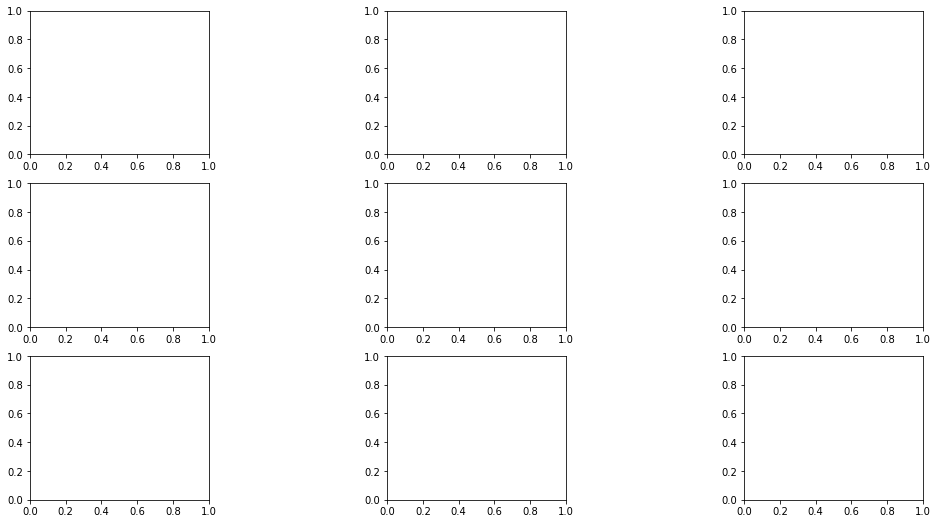

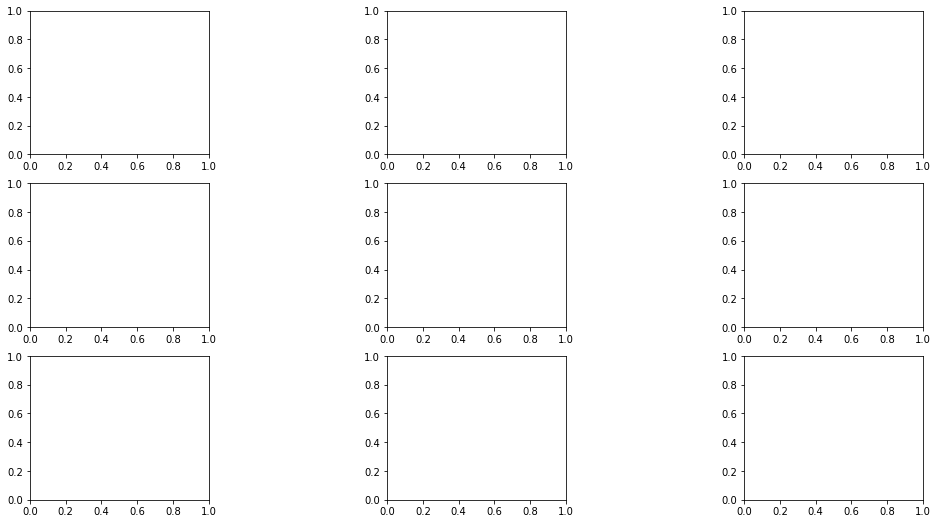

In [16]:
plt.show()

<h3>Part 3: Examining price breakdown based on region and restaurant category</h3>

Next, after examining the categorical breakdown based on county, we moved on to determine the price breakdown by both region and restaurant category. 

This was Randi's portion of the project. We ran into some tricky stuff with the stacked bar charts. The primary issue was that the each bar's list needed to be the same length, that was fine, except when there was a resturaunt for every price braket. Also, in all of her research Randi could not find how to make the stacked bars dynamic. In all the examples she found, the bar values were created manually. This is fine if you have a small dataset that you do not intend to run over and over again; however, this was not ideal for this project. 

<b>With some help from Mirko, Ryan, and Caleb, we figured it out! </b>

First, we needed to define this list we would be looping through. For the first chart, Number of \$ per Category, we created a list named labels that contained all the different resturaunt categories. Then, we created a second list with four empty lists. These four empty lists would represet 1\$, 2\$, 3\$, and 4\$. We then looped through our category list and found the count for each of the dollar ratings in said category. Once the loop determined how many 1\$, 2\$, 3\$, and 4\$ there were in each category it appended it to the corresponding empty list. If we did not find a 1\$, 2\$, 3\$, and 4\$ for a particular restuaunt category, then the except argument kicked-in and instead appended a zero. Again, the goal was to make each of the four lists the same length. 

In the end, we ended up with a list corresponding to 1\$, 2\$, 3\$, and 4\$, with ratings per restuarunt category. 

Once we created this loop and stored the counts in lists, we could call these lists in our chart creation; thereby, making the charts dynamic, changing with the number of pulls.

In [17]:
labels = ["Italian","Mexican","Chinese","American", "Indian"]
# Values of each group
bars =[[],[],[],[]]
for label in labels:
    df= res_df.loc[res_df["category"]==label, :]
    counts = df["price"].value_counts()
    for price in range(1,5):
        try:
            bars[price-1].append(counts[price])
        except: 
            bars[price-1].append(0)
print(bars[1])

[122, 48, 77, 159, 24]


<h3>Part 3: Stacked Bar Chart One - Number of $ per Category</h3>


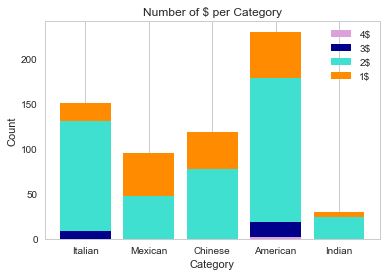

In [18]:
from matplotlib import rc
sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':False})



figsize= (100, 100, 50)
 
# Values of each group
bars1 = bars[0]
bars2 = bars[1]
bars3 = bars[2]
bars4 = bars[3]
x = np.arange(len(bars1))


four_dolla=plt.bar(x, bars4, color="plum")
three_dolla=plt.bar(x, bars3, color="darkblue", bottom=bars4)
two_dolla=plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
one_dolla=plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["Italian","Mexican","Chinese","American", "Indian"])

plt.grid(axis='y')
plt.xlabel("Category")
plt.ylabel('Price Count')
plt.title('Number of $ per Category')
    
plt.legend((four_dolla[0], three_dolla[0],two_dolla[0], one_dolla[0]), ('4$', '3$','2$', '1$'), loc="best")


# Show graphic
plt.show()
plt.savefig("stacked.png")

<h3>Part 3: Stacked Bar Chart Two - $ Breakdown by Region</h3>


In [19]:
region = ["NE","MW","WC","SW","SE"]
# Values of each group
r_bars =[[],[],[],[]]
for r in region:
    reg_bars= res_df.loc[res_df["Region"]==r, :]
    reg_counts = reg_bars["price"].value_counts()
    for price in range(1,5):
        try:
            r_bars[price-1].append(reg_counts[price])
        except: 
            r_bars[price-1].append(0)
print(r_bars)


[[77, 2, 50, 22, 16], [230, 4, 154, 36, 6], [17, 0, 7, 0, 2], [2, 0, 0, 0, 0]]


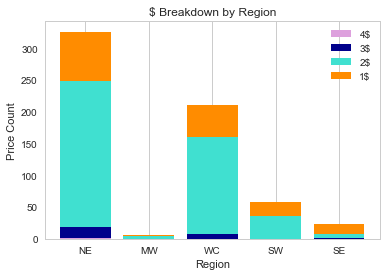

In [25]:
#### sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':False})

figsize= (300, 300, 25)
 
# Values of each group
bars1 = r_bars[0]
bars2 = r_bars[1]
bars3 = r_bars[2]
bars4 = r_bars[3]
x = np.arange(len(bars1))


four_dol = plt.bar(x, bars4, color="plum")
three_dol =plt.bar(x, bars3, color="darkblue", bottom=bars4)
two_dol =plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
one_dol =plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["NE","MW","WC","SW","SE","NE","WC","SE"])

plt.grid(axis='y')
plt.xlabel("Regions")
plt.ylabel('Price Count')
plt.title('$ Breakdown by Region')

plt.legend((four_dol[0], three_dol[0],two_dol[0], one_dol[0]), ('4$', '3$','2$', '1$'), loc="best")

# Show graphic
plt.show()
plt.savefig("stacked2.png")

<h3>Part 3: Pie Chart</h3>
    
With the dynamic stacked bar charts created, we thought it was relevant to also see the count of each dollar amount when comparing the counts by region or category. Thus, we created a pie chart (also dynamic) that shows the total of each resturaunt category by dollar. 

In [70]:
##check for pie chart
print(sum(bars1))
print(sum(bars2))
print(sum(bars3))
print(sum(bars4))

167
430
26
2


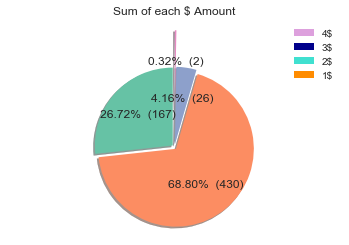

In [76]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sns.set()
orgPalette = sns.color_palette("Set2")
sns.set_palette(orgPalette)
# sns.set_style("", {'legend.frameon':False})

plt.figure(figsize=(20,20))

#labels = '4$', '3$','2$', '1$'
sizes = [sum(bars1),sum(bars2),sum(bars3),sum(bars4)]
explode = (0.03, 0.03, 0.03, 0.5)  # only "explode" the 2nd slice 

def make_autopct(sizes):
    def my_autopct(pct):
        total = sum(sizes)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, colors=orgPalette, autopct=make_autopct(sizes),
        shadow=True, startangle=90) 
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Sum of each $ Amount')
plt.legend((four_dol[0], three_dol[0],two_dol[0], one_dol[0]), ('4$', '3$','2$', '1$'), loc="best")


plt.show()
plt.savefig("pie_chart.jpg")

<h3>Part 4: MONICA</h3>
    

<h3>Part 5: CATHERINE</h3>

<h3>Part 6: Conclusions</h3>

<h3>Part 7: Limitations</h3>

<h3>Part 8: If only we had more time...</h3>